# 任务一 CNN手绘图像分类

## 1.1 读入图像并展示
1. 每类展示10个样本图像
2. 将‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’ 7个类的数据，每类按照7:2:1划分为“训练集”、“验证集”和“分布内测试集（IN-test）”
3. 将‘foot’,‘owl’,‘pig‘作为“分布外数据集”，每类抽取100张图像构成“分布外测试数据集（OOD-test）

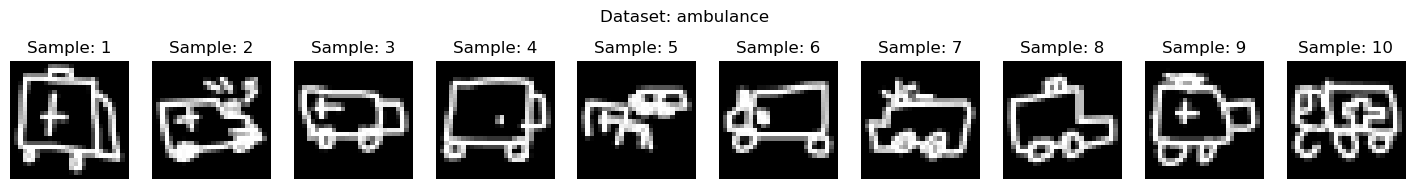

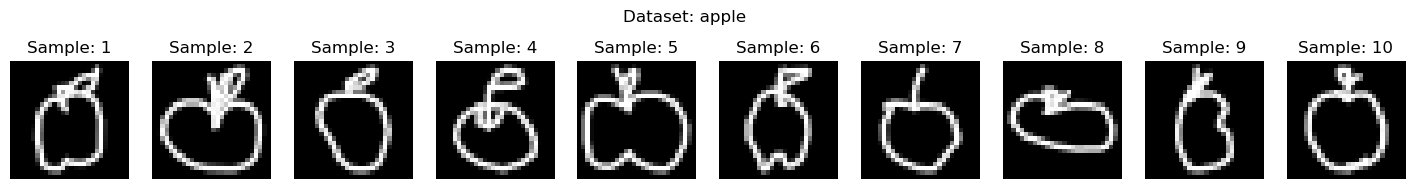

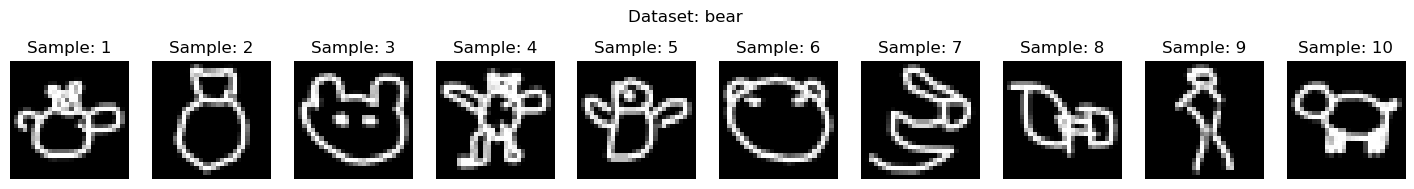

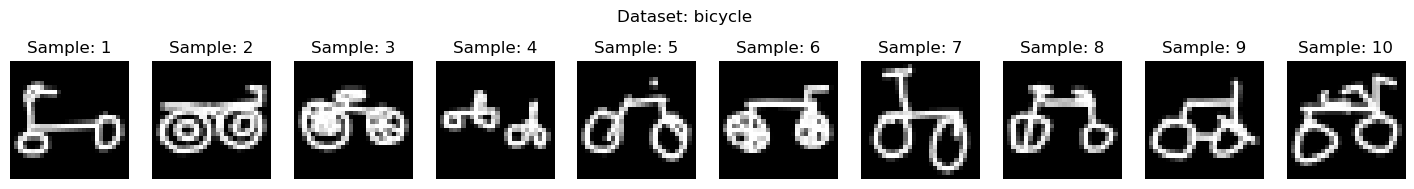

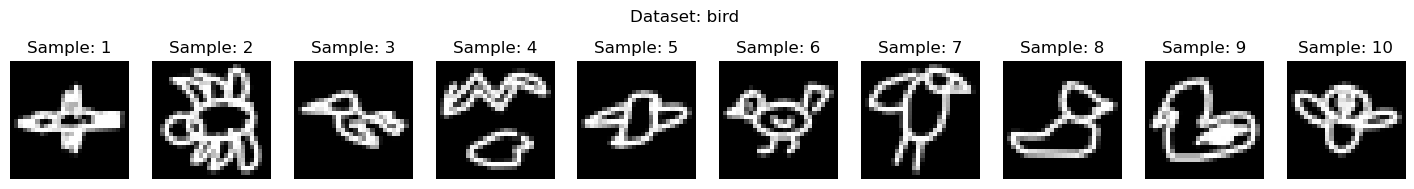

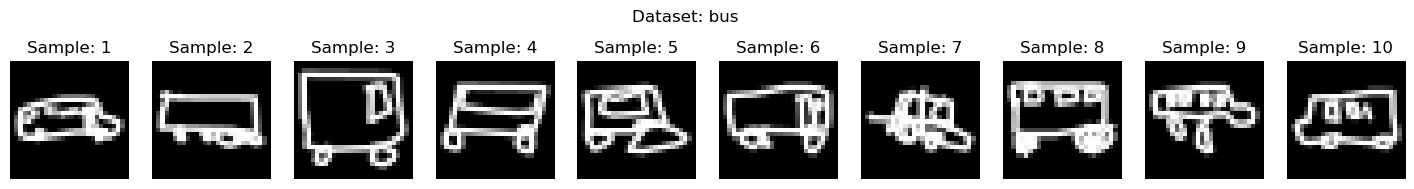

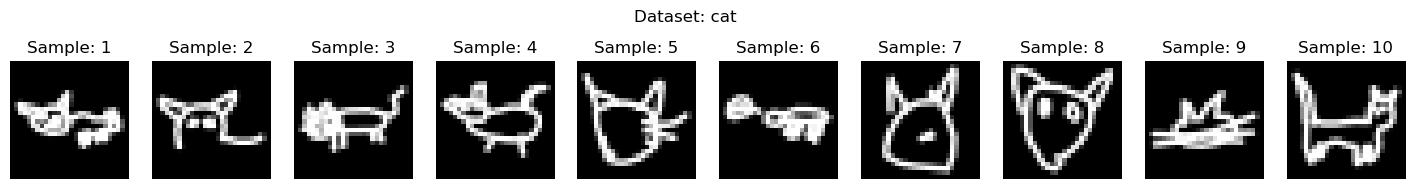

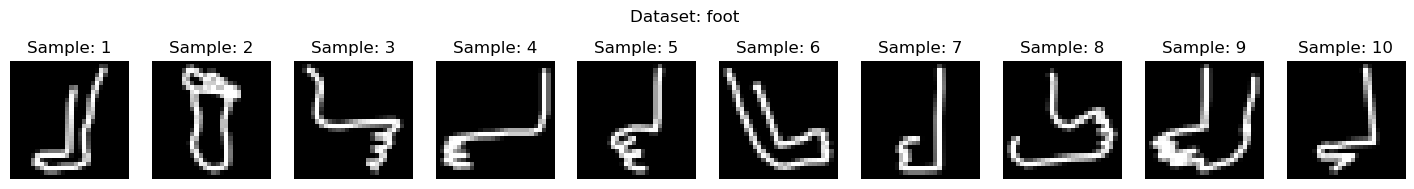

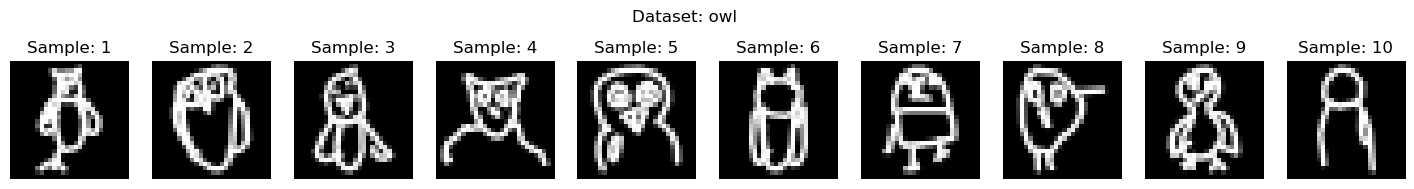

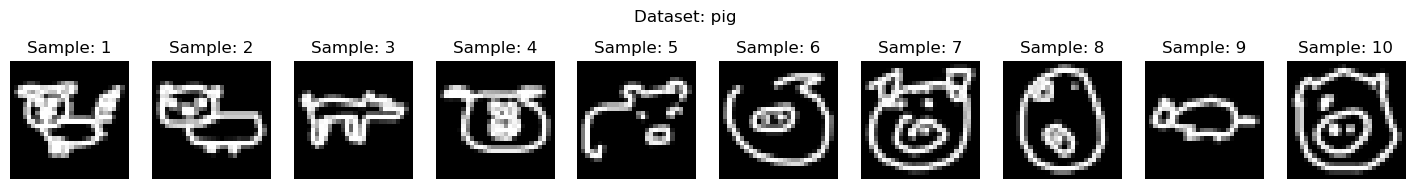

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取3个元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  

    # 绘图
    plt.figure(figsize=(18, 4))
    for i in range(show_num):
        plt.subplot(2, 10, i + 1) 

        image = random_samples[i].reshape(28, 28)

        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # 每张图片数据reshape
    data = []
    for pic in file:
        data.append(pic.reshape(1,28,28)) # channel，height，width
    

    return np.array(data) # 使用np数组

# 标签定义
# ‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’,‘foot’,‘owl’,‘pig‘
label = {0:'ambulance', 1:'apple', 2:'bear', 3:'bicycle', 4:'bird', 5:'bus', 6:'cat', 7:'foot', 8:'owl', 9:'pig'}

all_data = []

all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'ambulance', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'apple', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bear', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bicycle', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bird', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'bus', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'cat', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'foot', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'owl', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'pig', 10))

# numsample，channel，height，width
all_data = np.array(all_data) # 转为np数组


为了使用torch提供的dataloader，需要自定义一个dataset类。

In [3]:
# 生成可用的数据集
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index]

        return data, label


train_x = []
train_y = []
val_x = []
val_y = []
test_x_in = []
test_y_in = []
test_x_out = []
test_y_out = []

# 在原数据集中进行分割，输出list
for i in range(all_data.shape[0]):
    total_length = all_data[i].shape[0]

    # 分布外数据集
    if i >= 7:
        random_indices = np.random.choice(all_data[i].shape[0], 100, replace=False) # 每类抽取100张图像构成分布外测试数据集
        random_samples = all_data[i][random_indices] 

        test_x_out.extend(random_samples)
        test_y_out.extend([i]*100)

    # 分布内数据集
    else:
        split1 = int(total_length * 0.7)
        split2 = int(total_length * 0.9)

        train_x.extend(all_data[i][:split1])
        train_y.extend([i]*split1)
        val_x.extend(all_data[i][split1:split2])
        val_y.extend([i]*(split2-split1))
        test_x_in.extend(all_data[i][split2:])
        test_y_in.extend([i]*(total_length - split2))


train_data = MyDataset(train_x,train_y)
val_data = MyDataset(val_x,val_y)
test_data_in = MyDataset(test_x_in,test_y_in)
test_data_out = MyDataset(test_x_out,test_y_out)


print(np.array(train_data.data).shape)
print(np.array(train_data.labels).shape)


print(np.array(test_data_out.data).shape)
print(np.array(test_data_out.labels).shape)

# print(np.array(train_x).shape)
# print(np.array(train_x))

# print(np.array(train_y).shape)
# print(np.array(train_y))

(98000, 1, 28, 28)
(98000,)
(300, 1, 28, 28)
(300,)


## 1.2 使用pytorch搭建网络

In [4]:
from sympy import flatten
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# 构建LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        # 一个通道，10个分类
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) # 1*28*28 -> 6*28*28
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = self.pool(torch.sigmoid(self.conv2(x)))
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 1.3模型训练与验证

In [ ]:
def select_best_model(model):


### 1.3.1 LeNet模型训练

In [31]:
# 初始化模型
from random import shuffle
from sympy import true
import time


model = LeNet()  # 或者使用GoogLeNet
device = torch.device("mps")
model.to(device)


# 定义损失函数和优化器
CE = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True) # 尝试多个batch_size训练

# 模型选择
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
best_val_loss = float('inf')
best_model = model
best_epoch = 0
best_val_loss = 99999999


running_loss = []
start_time = time.time() # 记时
for epoch in range(num_epochs):
    running_loss.append(0.0) # 记录loss变化

    # 训练
    model.train()
    for x, y in train_loader:
        x = x.float().to(device)
        y = y.long().to(device)

        optimizer.zero_grad()
        y_hat = model(x)
        
        loss = CE(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss[epoch] += loss.item()

    # 验证与选优,早停
    if epoch > num_epochs/3:
        model.eval()
        
        # 观察cost记录中最后10个数据，如果变化幅度不超过1%，就停止
        stop_flag = False
        if len(running_loss) > 10:
            last_10_costs = np.array(running_loss)[-10:]
            max_cost = max(last_10_costs)
            min_cost = min(last_10_costs)
            if (max_cost - min_cost) / max_cost < 0.01:
                stop_flag = True
        if stop_flag:
            print(f"Training stopped due to small loss change in epoch {epoch}.")
            break    

        # 选优
        with torch.no_grad():
            val_loss = 0.0
            for x, y in val_loader:
                x = x.float().to(device)
                y = y.long().to(device)

                y_hat = model(x)
                loss = CE(y_hat, y)
                val_loss += loss.item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_epoch = epoch
                print(f"best model updated in epoch {epoch}! val loss: {best_val_loss:.3f}")
        
    # 过程信息打印
    if epoch % 10 == 0:
        epoch_end_time = time.time()
        print(f"epoch: {epoch+1 :3} cost {(epoch_end_time - start_time):.2f}s after last print, sum loss: {running_loss[epoch]:.3f}")
        start_time = epoch_end_time

        
print(f"Finished Training, best model saved in epoch {best_epoch+1} with val loss: {best_val_loss:.3f}")

# 保存模型
torch.save(best_model.state_dict(), "trained_model.pth")

epoch:   1 cost 2.78s after last print, sum loss: 190.092
best model updated in epoch 7! val loss: 149.922
best model updated in epoch 8! val loss: 149.800
best model updated in epoch 9! val loss: 144.135
best model updated in epoch 10! val loss: 140.200
epoch:  11 cost 29.97s after last print, sum loss: 49.452
best model updated in epoch 11! val loss: 135.268
best model updated in epoch 12! val loss: 133.345
best model updated in epoch 13! val loss: 131.467
best model updated in epoch 14! val loss: 126.835
best model updated in epoch 16! val loss: 124.397
best model updated in epoch 17! val loss: 122.708
best model updated in epoch 18! val loss: 122.071
Finished Training, best model saved in epoch 19 with val loss: 122.071
